# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
final = final.sort_values(['Time'], axis=0)
final.head(30000)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe..."
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...
61299,66610,B0000SY9U4,A3EEDHNHI4WNSH,Joanna J. Young,23,23,1,1067472000,Yummy,"If you've never tried Kona coffee, Aloha Islan..."
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,1,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to..."
38889,42227,B0000A0BS8,A1IU7S4HCK1XK0,Joanna Daneman,5,5,1,1067644800,I gave up on other coffees,The grocery store has all kinds of &quot;gourm...
38888,42226,B0000A0BS8,A23GFTVIETX7DS,Debbie Lee Wesselmann,5,5,1,1067904000,Five stars if you like Starbucks,This blend is one of Starbucks' gentler blends...
10992,11991,B0000T15M8,A2928LJN5IISB4,chatchi,5,5,1,1067990400,The fruits of my labor,When chatchi's favorite afternoon treat became...


In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!<br /><br />(For those wo

In [17]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [18]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had "attracted" many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.
I have made these brownies for family and for a den of cub scouts and no one would have known they were gluten free and everyone asked for seconds!  These brownies have a fudgy texture and have bits of chocolate chips in them which are delicious.  I would say the mix is very thick and a little difficult to work with.  The cooked brownies are slightly difficult to cut into very neat edges as the edges tend to crumble a little and I would also say that they make a slightly thinner layer of brownies than most of the store brand gluten containing but they taste just as good, if not better.  Highly recommended!(For those wondering, this mix requ

In [19]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [22]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

tangy ginger flavor - very pleasing to the senses; only takes a small amount to make a delicious cup of hot tea or iced tea in a pitcher for the refrigerator


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I bought a few of these after my apartment was infested with fruit flies. After only a few hours, the trap had &quot;attracted&quot; many flies and within a few days they were practically gone. This may not be a long term  solution, but if flies are driving you crazy, consider buying this. One  caution- the surface is very sticky, so try to avoid touching it.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This gum is my absolute favorite By purchasing on amazon I can get the savings of large quanities at a very good price I highly recommend to all gum chewers Plus as you enjoy the peppermint flavor and freshing of breath you are whitening your teeth all at the same time 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:17<00:00, 1131.88it/s]


In [24]:
preprocessed_reviews[1500]

'gum absolute favorite purchasing amazon get savings large quanities good price highly recommend gum chewers plus enjoy peppermint flavor freshing breath whitening teeth time'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
from bs4 import BeautifulSoup
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', '', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:02<00:00, 1413.55it/s]


In [25]:
preprocessed_summary[1000]

'thecandyblockswereanicevisualforthelegobirthdaypartybutthecandyhaslittletastetoitverylittleofthelbsthatiboughtwereeatenandithrewtherestawayiwouldnotbuythecandyagain'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaaarrrrrggghhh', 'aaaaaawwwwwwwwww', 'aaaaah']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 54904)
the number of unique words  54904


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (87773, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abdominal', 'ability', 'able', 'able add', 'able brew']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (87773, 51709)
the number of unique words including both unigrams and bigrams  51709


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8557394742965698), ('awesome', 0.8544305562973022), ('good', 0.8317395448684692), ('excellent', 0.8125078678131104), ('terrific', 0.8124305605888367), ('perfect', 0.768768846988678), ('wonderful', 0.7649434804916382), ('decent', 0.7272575497627258), ('amazing', 0.7244181632995605), ('nice', 0.7115830779075623)]
[('greatest', 0.8054407238960266), ('best', 0.7326244711875916), ('tastiest', 0.7158212661743164), ('disgusting', 0.6699162721633911), ('nastiest', 0.6681627631187439), ('horrible', 0.6205527186393738), ('surpass', 0.61661297082901), ('awful', 0.607093095779419), ('nicest', 0.6068994402885437), ('smoothest', 0.601479709148407)]


In [30]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  17386
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'squishing', 'buggers', 'success', 'rate']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [05:33<00:00, 263.02it/s]


87773
50


#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [33]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 87773/87773 [1:18:20<00:00, 15.56it/s]


# [5] Assignment 3: KNN

<ol>
    <li><strong>Apply Knn(brute force version) on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Apply Knn(kd tree version) on these feature sets</strong>
        <br><font color='red'>NOTE: </font>sklearn implementation of kd-tree accepts only dense matrices, you need to convert the sparse matrices of CountVectorizer/TfidfVectorizer into dense matices. You can convert sparse matrices to dense using .toarray() attribute. For more information please visit this <a href='https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.sparse.csr_matrix.toarray.html'>link</a>
        <ul>
            <li><font color='red'>SET 5:</font>Review text, preprocessed one converted into vectors using (BOW) but with restriction on maximum features generated.
            <pre>
            count_vect = CountVectorizer(min_df=10, max_features=500) 
            count_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 6:</font>Review text, preprocessed one converted into vectors using (TFIDF) but with restriction on maximum features generated.
            <pre>
                tf_idf_vect = TfidfVectorizer(min_df=10, max_features=500)
                tf_idf_vect.fit(preprocessed_reviews)
            </pre>
            </li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best K)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'> link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW,<font color='red'> SET 1</font>

In [25]:
# Please write all the code with proper documentation
final['Text']=preprocessed_reviews

data_pos = final[final["Score"] == 1].sample(n=20000)
data_neg = final[final["Score"] == 0].sample(n=10000)
final1 = pd.concat([data_pos, data_neg])
final1.shape

(30000, 10)

In [26]:
Y = final1['Score'].values
X = final1['Text'].values
print(Y.shape)
print(type(Y))
print(X.shape)
print(type(X))

(30000,)
<class 'numpy.ndarray'>
(30000,)
<class 'numpy.ndarray'>


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

X_tr,X_test,Y_tr,Y_test=train_test_split(X,Y,test_size=0.2,random_state=12)
X_train,X_cv,Y_train,Y_cv=train_test_split(X_tr,Y_tr,test_size=0.2,random_state=12)
print('='*100)
print("After splitting")
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

After splitting
(19200,) (19200,)
(4800,) (4800,)
(6000,) (6000,)


# BOW

In [28]:
vectorizer=CountVectorizer()
vectorizer=vectorizer.fit(X_train)
X_train_bow=vectorizer.transform(X_train)
X_cv_bow=vectorizer.transform(X_cv)
X_test_bow=vectorizer.transform(X_test)
print('='*100)
print("After transform")
print(X_train_bow.shape,Y_train.shape)
print(X_cv_bow.shape,Y_cv.shape)
print(X_test_bow.shape,Y_cv.shape)

After transform
(19200, 27024) (19200,)
(4800, 27024) (4800,)
(6000, 27024) (4800,)


In [29]:
print(Y_train.shape)
print(Y_cv.shape)

(19200,)
(4800,)


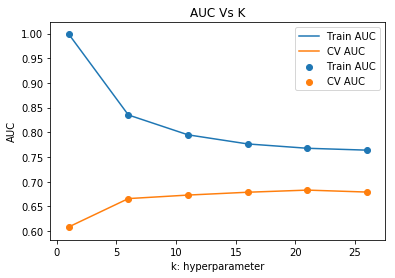

In [43]:
train_auc = []
cv_auc = []
k = list(range(1, 30, 5))
for i in (k):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute', weights='uniform')
    neigh.fit(X_train_bow, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(X_train_bow)[:,1]
    Y_cv_pred = neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(1, 30, 5))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=20, algorithm='brute')
    scores = cross_val_score(knn, X_train_bow, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:14<00:00, 22.65s/it]


In [89]:
#As per the above metrics we took k=20 as our optimal hyperparameter.
optimal_k1 = KNeighborsClassifier(n_neighbors=20, algorithm='brute', weights='uniform')
optimal_k1.fit(X_train_bow, Y_train)
prediction = optimal_k1.predict(X_test_bow)

# Plotting ROC Curve

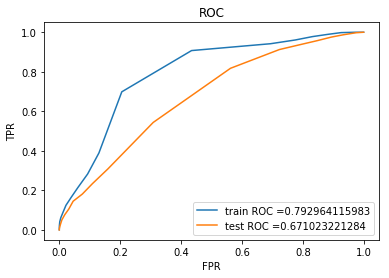

In [63]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_bow)[:,1])
AUC1=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

# Confusion Matrix

Train confusion matrix
[[4428 2015]
 [1840 4517]]
Test confusion matrix
[[1189  765]
 [ 685 1361]]


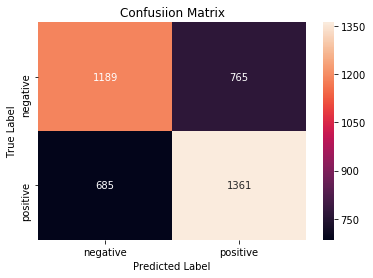

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=20, algorithm='brute', weights='uniform')
optimal_model.fit(X_train_bow, Y_train)
prediction = optimal_model.predict(X_test_bow)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(X_train_bow))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(X_test_bow)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_bow))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Confusion Matrix Describes: (# Means Number Of) , P:Positive, N:Negative
* TPR(True Positive Rate) : #TP/P 
* TNR(True Negative Rate) : #TN/N
* FPR(False Positive Rate): #FP/N
* FNR(False Negative Rate): #FN/P
* N+P = n(Total No Of Points)

### Observations
 * From Above ConfusionMatrix And Classification Report Of the Classifier.
 * TruePositive : 1361, TrueNegative: 765, FlasePositive: 685, FalseNegative: 1189
 * Based On Classification report(i.e:, how often classifier is correctly predicting)
   (TP+TN)/N = (1361+765)/4000 = ~65%
 * Error rate or MissClassification Rate (i.e:, wrongly classified points) 
   (FN+FP)/N = (1189+685)/4000 = ~34%
 * Precision: PR=TP/(TP+FP) = ~62% (i.e:, What %age of them actually positive)
 * Recall(TPR=TP/P): (i.e:, Of all actual +ve points what %age of them predicted to be +ve)
   ~0.84%
 * F1-Score(combining both precision & Recall) : HarmonicMean Of Precision And Recall.
 * Support is no of elements in each of the classes(+ve & -ve).
 * Miscalssification Vs OptimalNeighbors as K increases, classification error decreases.
 * By using unseen data(Test Data) accuracy=0.76% where optimal k =96.
 * From confusion Matrix out of 4k unseen data points classifier predicted 1954 -ve points, 2046 +ve points.
 * Generalization error is high means model doesn't perform well on unseen/future data.

### [5.1.2] Applying KNN brute force on TFIDF,<font color='red'> SET 2</font>

In [66]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5)
tf_idf_vect.fit(X_train)
X_train_tfidf=tf_idf_vect.transform(X_train)
X_cv_tfidf=tf_idf_vect.transform(X_cv)
X_test_tfidf=tf_idf_vect.transform(X_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:43<00:00, 12.74s/it]


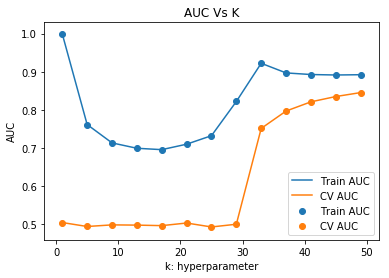

In [62]:
train_auc = []
cv_auc = []
k = list(range(1, 50, 4))
for i in tqdm(k):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute', weights='uniform')
    neigh.fit(X_train_tfidf, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(X_train_tfidf)[:,1]
    Y_cv_pred = neigh.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(1, 50, 4))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=49, algorithm='brute', weights='uniform')
    scores = cross_val_score(knn, X_train_tfidf, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:00<00:00,  9.40s/it]


In [90]:
#As per the above metrics we took k=49 as our optimal hyperparameter.
optimal_k2 = KNeighborsClassifier(n_neighbors=49, algorithm='brute', weights='uniform')
optimal_k2.fit(X_train_tfidf, Y_train)
prediction = optimal_k2.predict(X_test_tfidf)

# Plotting ROC Curve

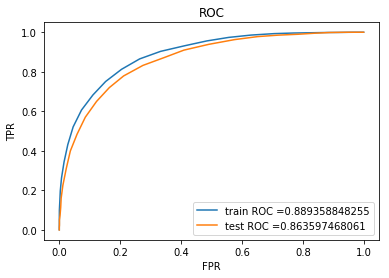

In [68]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(X_test_tfidf)[:,1])
AUC2=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

# Confusion Matrix

Train confusion matrix
[[3912 2531]
 [ 443 5914]]
Test confusion matrix
[[1085  869]
 [ 219 1827]]


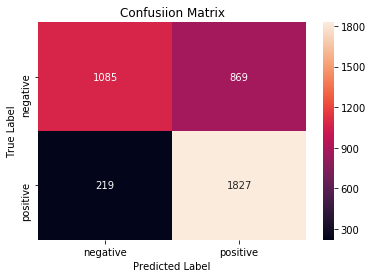

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=49, algorithm='brute', weights='uniform')
optimal_model.fit(X_train_tfidf, Y_train)
prediction = optimal_model.predict(X_test_tfidf)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(X_train_tfidf))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(X_test_tfidf))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Observation:
 * using future data model accuracy is 0.86 where optimal k is 49.
 * From Confusion Matrix it is predicted that 1954 -ve points , 2046 +ve points
   but in real 2293+ve points are there, 1707 -ve points are there.

### [5.1.3] Applying KNN brute force on AVG W2V,<font color='red'> SET 3</font>

In [69]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7094
sample words  ['looking', 'forward', 'replacement', 'shipment', 'amazon', 'every', 'single', 'dented', 'cans', 'packaged', 'larger', 'box', 'really', 'big', 'air', 'packs', 'like', 'giant', 'bubbles', 'bubble', 'wrap', 'around', 'obviously', 'arrived', 'plastic', 'nothing', 'stop', 'someone', 'would', 'think', 'pack', 'could', 'pound', 'set', 'without', 'popping', 'beyond', 'sending', 'replacements', 'hoping', 'not', 'seen', 'commercials', 'tv', 'thought', 'since', 'naturally', 'fine', 'un', 'treated']


In [70]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

(12800, 50)
[ 0.5097253  -0.15761172 -0.98187558 -0.49180779 -0.60491929 -0.1400248
 -0.05724474 -0.1611897  -0.1842317  -0.5772106  -0.49776121 -0.48667477
  0.37650072  0.19224389  0.07446003 -0.18766239  0.79307534 -0.39514386
 -0.36595743 -0.62516787 -0.35401888  0.40647448 -0.09550583  0.07385785
  0.40285964  0.51162122 -0.29402261 -0.31955392 -0.25834229 -0.23348109
 -0.16882875 -0.28285529 -0.46541077 -0.08484117  0.07754844 -0.89334504
 -0.17554198  0.31087591 -0.9256887  -0.21788658 -0.41003739 -0.18564319
 -0.34261984  0.42507684  0.32189861 -0.15699348 -0.34849344  0.13146843
  0.33157122 -0.09277704]


In [73]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:07<00:00, 421.25it/s]


(3200, 50)
[-0.03325754  0.3523769   0.08983543  0.15940659  0.423988    0.41867245
  0.12234944  0.19677119  0.5650364   0.29335354  0.07982238  0.63356387
  0.27414457 -0.64527585  0.09705253  0.39448643 -0.27016103  0.01494447
  0.43698831 -0.11805555  0.6001468  -0.11465883  0.33496194 -0.31849303
  0.18812681 -0.86002196  0.4165638  -0.29186559 -0.05454733 -0.40460723
 -0.3290189  -0.32899801  0.30367968 -0.28826689  0.34240247  0.53812437
 -0.28198185 -0.24394272  0.10045772 -0.09942575  1.0819461   0.64881333
 -0.34368667  0.28719202  0.17372985 -0.0551892  -0.19554388 -0.11547621
  0.08789     0.31925108]


In [72]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in (list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

(4000, 50)
[ 0.34806705  0.29548332 -1.19285869 -0.52561498 -0.65886749 -0.05652549
 -0.10167414 -0.11191036 -0.22394349 -0.0458506  -0.67382281 -0.54236537
  0.19140052  0.43675589  0.19824981 -0.28258004  0.59908861 -0.18569906
 -0.29353612 -0.17871369 -0.25685934  0.38088331 -0.35416527  0.06036188
  0.00908717  0.50689791  0.00675612  0.14272982 -0.27498924 -0.12509584
  0.40970013 -0.0199179  -0.19435267  0.30690022  0.07161385 -0.38804171
 -0.27232161  0.66862669 -0.65574677  0.05975193 -0.35814347 -0.20950051
 -0.26713764  0.1572135  -0.04109593 -0.1815839  -0.44820425  0.11666733
  0.14991753 -0.22498539]


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.91s/it]


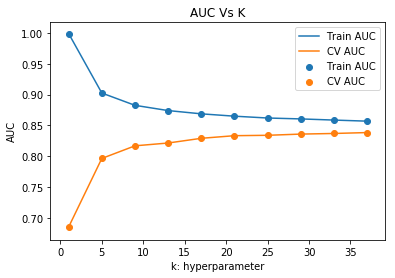

In [75]:
train_auc = []
cv_auc = []
k = list(range(1, 40, 4))
for i in tqdm(k):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute',weights='uniform')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [36]:
neighbors = list(range(1, 40, 4))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=31, algorithm='brute', weights='uniform')
    scores = cross_val_score(knn, sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean())

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:47<00:00,  4.82s/it]


In [91]:
#As per the above metrics we took k=31 as our optimal hyperparameter.
optimal_k3 = KNeighborsClassifier(n_neighbors=31, algorithm='brute', weights='uniform')
optimal_k3.fit(sent_vectors_train, Y_train)
prediction = optimal_k3.predict(sent_vectors_test)

# Plotting ROC Curve

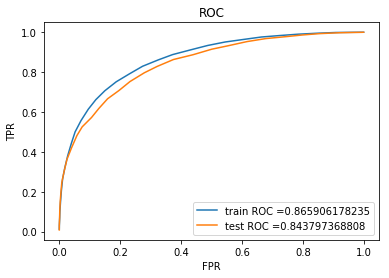

In [74]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC3=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

# Confusion Matrix

Train confusion matrix
[[5227 1216]
 [1634 4723]]
Test confusion matrix
[[1569  385]
 [ 575 1471]]


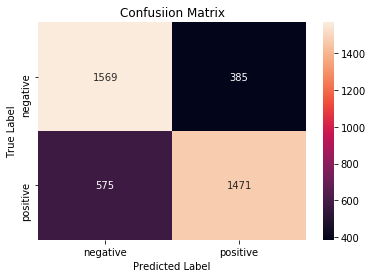

In [79]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=31, algorithm='brute', weights='uniform')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_test)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Using bruteForcce Model KNN AVGW2V optimal hyperparameter is 31 with an accuracy 0f 0.85%

### [5.1.4] Applying KNN brute force on TFIDF W2V,<font color='red'> SET 4</font>

In [42]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [44]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12800/12800 [16:06<00:00, 13.25it/s]


In [46]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3200/3200 [01:01<00:00, 51.78it/s]


In [47]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:22<00:00, 48.69it/s]


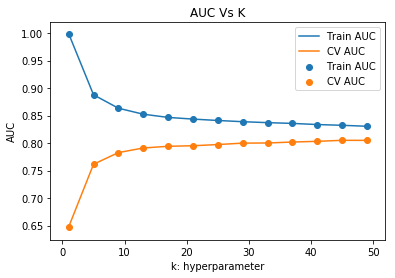

In [85]:
train_auc = []
cv_auc = []
k = list(range(1,50,4))
for i in k:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='brute', weights='uniform')
    neigh.fit(tfidf_sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [39]:
neighbors = list(range(1,50,4))
cv_score=[]
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=45, algorithm='brute', weights='uniform')
    scores = cross_val_score(knn, tfidf_sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean())  

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:03<00:00,  5.01s/it]


In [92]:
#As per the above metrics we took k=45 as our optimal hyperparameter.
optimal_k4 = KNeighborsClassifier(n_neighbors=45, algorithm='brute', weights='uniform')
optimal_k4.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_k4.predict(tfidf_sent_vectors_test)

##  Plotting ROC Curve

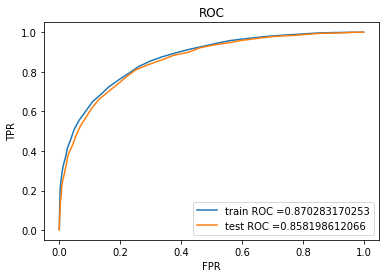

In [49]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC4=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

## Confusion Matrix

Train confusion matrix
[[4875 1568]
 [1617 4740]]
Test confusion matrix
[[1455  499]
 [ 543 1503]]


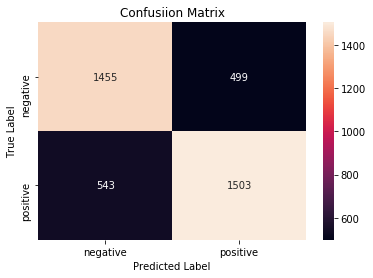

In [90]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=45, algorithm='brute', weights='uniform')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_test)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(tfidf_sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Using BruteForce Model Of KNN optimal HyperParameter is 45 with an accuracy of 0.82%
* Miscalssification Vs Optimal K it shows Classification error for each K value, which is decreasing for each Of the K.

## [5.2] Applying KNN kd-tree

### [5.2.1] Applying KNN kd-tree on BOW,<font color='red'> SET 5</font>

In [32]:
# Please write all the code with proper documentation
data_pos1 = final[final["Score"] == 1].sample(n = 10000)
data_neg1 = final[final["Score"] == 0].sample(n = 10000)
final2 = pd.concat([data_pos1,data_neg1])
final2.shape

B = final2['Score'].values
A = final2['Text'].values
print(B.shape)
print(type(B))
print(A.shape)
print(type(A))

(20000,)
<class 'numpy.ndarray'>
(20000,)
<class 'numpy.ndarray'>


In [33]:
A_tr,A_test,B_tr,B_test=train_test_split(A,B,test_size=0.2,random_state=12)
A_train,A_cv,B_train,B_cv=train_test_split(A_tr,B_tr,test_size=0.2,random_state=12)
print('='*100)
print("After splitting")
print(A_train.shape,B_train.shape)
print(A_cv.shape,B_cv.shape)
print(A_test.shape,B_test.shape)

After splitting
(12800,) (12800,)
(3200,) (3200,)
(4000,) (4000,)


In [34]:
vectorizer=CountVectorizer(min_df=10, max_features=500)
vectorizer=vectorizer.fit(A_train)
A_train_bow_kdtree=vectorizer.transform(A_train)
A_cv_bow_kdtree=vectorizer.transform(A_cv)
A_test_bow_kdtree=vectorizer.transform(A_test)
print('='*100)
print("After transform")
print(A_train_bow_kdtree.shape,B_train.shape)
print(A_cv_bow_kdtree.shape,B_cv.shape)
print(A_test_bow_kdtree.shape,B_cv.shape)

After transform
(12800, 500) (12800,)
(3200, 500) (3200,)
(4000, 500) (3200,)


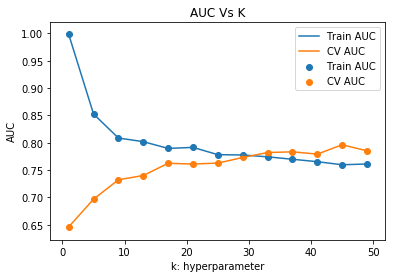

In [95]:
train_auc = []
cv_auc = []
K = list(range(1,50,4))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_bow_kdtree.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred =  neigh.predict_proba(A_train_bow_kdtree.todense())[:,1]
    B_cv_pred =  neigh.predict_proba(A_cv_bow_kdtree.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))
plt.plot(K, train_auc, label='Train AUC')
plt.scatter(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.scatter(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(1,50,4))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_bow_kdtree.todense(), B_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean())  

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


In [93]:
#As per the above metrics we took k=25 as our optimal hyperparameter.
optimal_k5 = KNeighborsClassifier(n_neighbors=25, algorithm='kd_tree')
optimal_k5.fit(A_train_bow_kdtree.todense(), B_train)
prediction = optimal_k5.predict(A_test_bow_kdtree.todense())

## Plotting ROC Curve

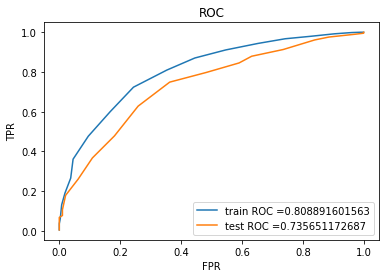

In [54]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_bow_kdtree.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_bow_kdtree.todense())[:,1])
AUC5=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

## Confusion Matrix

Train confusion matrix
[[492 148]
 [205 435]]
Test confusion matrix
[[148  45]
 [ 88 119]]


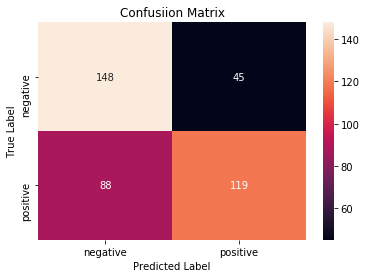

In [99]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=25, algorithm='kd_tree', weights='uniform')
optimal_model.fit(A_train_bow_kdtree.todense(), B_train)
prediction = optimal_model.predict(A_train_bow_kdtree.todense())
print("Train confusion matrix") 
print(confusion_matrix(B_train, optimal_model.predict(A_train_bow_kdtree.todense()))) 
print("Test confusion matrix")
print(confusion_matrix(B_test, optimal_model.predict(A_test_bow_kdtree.todense())))
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_bow_kdtree.todense()))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Using Kd-tree Model Of KNN BOW optimal Hyperparameter is 47 with an accuracy of 72%.
* As the Dimensionality is high which leads to o(nd) than o(log(n)) , using kd-tree is useless.


### [5.2.2] Applying KNN kd-tree on TFIDF,<font color='red'> SET 6</font>

In [55]:
# Please write all the code with proper documentation
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=500)
tf_idf_vect.fit(A_train)
A_train_tfidf=tf_idf_vect.transform(A_train)
A_cv_tfidf=tf_idf_vect.transform(A_cv)
A_test_tfidf=tf_idf_vect.transform(A_test)
print(A_train_tfidf.shape)

(1280, 2001)


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:04<00:00, 10.04s/it]


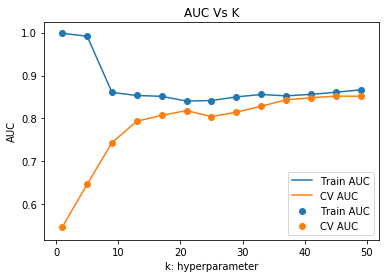

In [109]:
train_auc = []
cv_auc = []
k=[]
k = list(range(1,50,4))
for i in tqdm(k):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(A_train_tfidf.todense(), B_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    B_train_pred = neigh.predict_proba(A_train_tfidf.todense())[:,1]
    B_cv_pred = neigh.predict_proba(A_cv_tfidf.todense())[:,1]
    
    train_auc.append(roc_auc_score(B_train,B_train_pred))
    cv_auc.append(roc_auc_score(B_cv, B_cv_pred))
    k.append(i)
    
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(1,50,4))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, A_train_tfidf.todense(), B_train, cv=3, scoring='accuracy')
    cv_score.append(scores.mean())  

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [01:08<00:00,  5.25s/it]


In [94]:
#As per the above metrics we took k=35 as our optimal hyperparameter.
optimal_k6 = KNeighborsClassifier(n_neighbors=35, algorithm='kd_tree')
optimal_k6.fit(A_train_tfidf.todense(), B_train)
prediction = optimal_k6.predict(A_test_tfidf.todense())

## Plotting ROC Curve

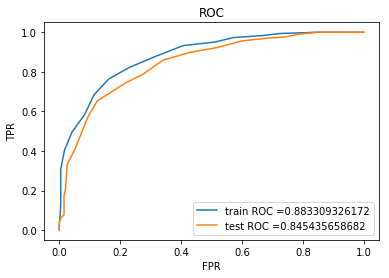

In [57]:
train_fpr, train_tpr, thresholds = roc_curve(B_train, optimal_model.predict_proba(A_train_tfidf.todense())[:,1])
test_fpr, test_tpr, thresholds = roc_curve(B_test, optimal_model.predict_proba(A_test_tfidf.todense())[:,1])
AUC6=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

## Confusion Matrix

Train confusion matrix
[[466 174]
 [122 518]]
Test confusion matrix
[[147  46]
 [ 50 157]]


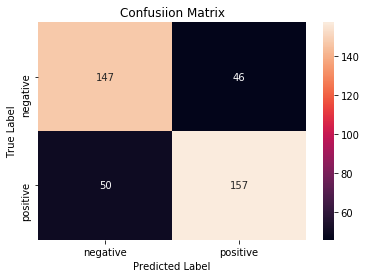

In [112]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=35, algorithm='kd_tree')
optimal_model.fit(A_train_tfidf.todense(), B_train)
prediction = optimal_model.predict(A_train_tfidf.todense())
print("Train confusion matrix") 
print(confusion_matrix(B_train, optimal_model.predict(A_train_tfidf.todense()))) 
print("Test confusion matrix")
print(confusion_matrix(B_test, optimal_model.predict(A_test_tfidf.todense())))
conf_matrix = confusion_matrix(B_test, optimal_model.predict(A_test_tfidf.todense()))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### Observation:
* Using Tfidf kd-tree Optimal Hyperparameter is 35, with an accuracy of 0.79%.
* kd-tree performs well for small dimensional data.

### [5.2.3] Applying KNN kd-tree on AVG W2V,<font color='red'> SET 3</font>

In [76]:
# Please write all the code with proper documentation
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())

# this line of code trains your w2v model on the give list of sentances
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  7094
sample words  ['looking', 'forward', 'replacement', 'shipment', 'amazon', 'every', 'single', 'dented', 'cans', 'packaged', 'larger', 'box', 'really', 'big', 'air', 'packs', 'like', 'giant', 'bubbles', 'bubble', 'wrap', 'around', 'obviously', 'arrived', 'plastic', 'nothing', 'stop', 'someone', 'would', 'think', 'pack', 'could', 'pound', 'set', 'without', 'popping', 'beyond', 'sending', 'replacements', 'hoping', 'not', 'seen', 'commercials', 'tv', 'thought', 'since', 'naturally', 'fine', 'un', 'treated']


In [77]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 12800/12800 [00:27<00:00, 458.95it/s]


(12800, 50)
[ 0.57002389 -0.19142722 -0.91318027 -0.46264983 -0.66959189 -0.18148847
 -0.0387166  -0.11890846 -0.35907673 -0.4690472  -0.40737508 -0.33755502
  0.25542107  0.18462662 -0.00367541 -0.13180659  0.7485175  -0.31244142
 -0.31007441 -0.76631732 -0.40014918  0.45603848 -0.17146673  0.09089312
  0.55625857  0.52078965 -0.25958927 -0.40585373 -0.33015837 -0.16890456
 -0.07969888 -0.26754988 -0.45873276 -0.09568345 -0.01023829 -0.90435297
 -0.08785287  0.50241591 -0.95325556 -0.06506444 -0.32674686 -0.15891251
 -0.31300288  0.42628838  0.34670384 -0.1575188  -0.3883039   0.14108389
  0.27111791 -0.17757752]


In [51]:
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])


100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:07<00:00, 442.17it/s]


(3200, 50)
[-0.32380254 -0.28209417 -0.67050233  0.36015612  0.1300125   0.60752444
 -0.23817101 -0.13350595  0.28610069 -0.23993398 -0.04269226  0.24448253
  0.6635983  -0.52866026 -0.76694786 -0.15542161  0.46229306 -0.38566272
 -0.4382967   0.892316    0.03434319  0.11700746  0.59598924 -0.5560184
 -0.08221379  0.79890455  0.51180161  1.09111921  0.20941242 -1.50001975
  0.06142278 -0.14193016 -0.8560413   1.09155197 -0.09063884 -0.4972069
 -0.4813479  -0.47284985 -0.29933688 -0.3037536   0.08785896  0.43757894
 -0.2169831   0.555793   -1.21391956  0.26765631  1.17333199 -0.39813629
  0.16989206  0.44953476]


In [78]:
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:09<00:00, 431.06it/s]


(4000, 50)
[ 0.31122511  0.25168502 -0.96755603 -0.45621426 -0.74862376  0.03619628
 -0.07199714 -0.08182884 -0.40624109 -0.02987557 -0.78726963 -0.46030767
  0.10088088  0.45336218  0.20844278 -0.21644972  0.63514167 -0.25043278
 -0.30386107 -0.24133059 -0.25480378  0.43985867 -0.43456114  0.11002586
  0.04958925  0.43394797  0.01825007  0.11882159 -0.24975347 -0.16143425
  0.36133478 -0.00171435 -0.1951505   0.26031045  0.07386738 -0.50260858
 -0.13405572  0.70317337 -0.65653011  0.16558676 -0.51013962 -0.10262701
 -0.15575681  0.07707385  0.10995714 -0.30643245 -0.37400435  0.18542747
  0.14500935 -0.35902857]


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [04:32<00:00, 23.24s/it]


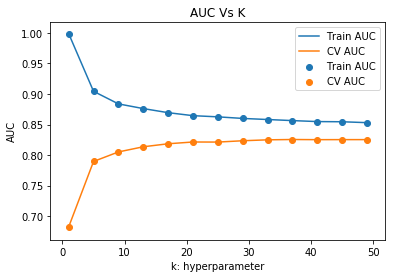

In [53]:
from tqdm import tqdm
train_auc = []
cv_auc = []
k = list(range(1,50,4))
for i in tqdm(k):
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [54]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
neighbors = list(range(1,50,4))
cv_score = []
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, sent_vectors_train, Y_train, cv=10, scoring='f1')
    cv_score.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [03:34<00:00, 18.07s/it]


In [95]:
#As per the above metrics we took k=49 as our optimal hyperparameter.
optimal_k7 = KNeighborsClassifier(n_neighbors=49, algorithm='kd_tree')
optimal_k7.fit(sent_vectors_train, Y_train)
prediction = optimal_k7.predict(sent_vectors_test)

## Plotting ROC Curve

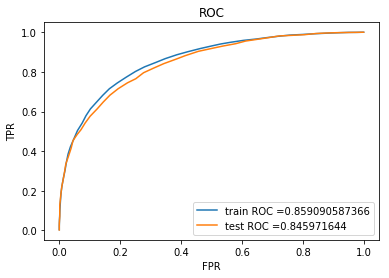

In [81]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(sent_vectors_test)[:,1])
AUC7=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

## Confusion Matrix

Train confusion matrix
[[5194 1249]
 [1669 4688]]
Test confusion matrix
[[1574  380]
 [ 576 1470]]


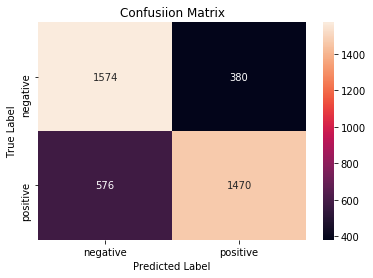

In [126]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=49, algorithm='kd_tree')
optimal_model.fit(sent_vectors_train, Y_train)
prediction = optimal_model.predict(sent_vectors_train)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(sent_vectors_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### [5.2.4] Applying KNN kd-tree on TFIDF W2V,<font color='red'> SET 4</font>

In [82]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [83]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 12800/12800 [04:15<00:00, 50.46it/s]


In [58]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3200/3200 [00:14<00:00, 227.21it/s]


In [84]:
#TF-IDF weighted word2vec
i=0
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [01:24<00:00, 47.59it/s]


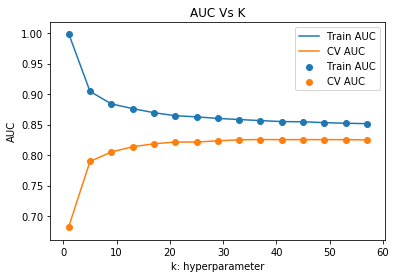

In [60]:
train_auc = []
cv_auc = []
k = list(range(1,60,4))
for i in k:
    neigh = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
    neigh.fit(sent_vectors_train, Y_train)
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs
    Y_train_pred = neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred = neigh.predict_proba(sent_vectors_cv)[:,1]
    
    train_auc.append(roc_auc_score(Y_train,Y_train_pred))
    cv_auc.append(roc_auc_score(Y_cv, Y_cv_pred))
    
plt.plot(k, train_auc, label='Train AUC')
plt.scatter(k, train_auc, label='Train AUC')
plt.plot(k, cv_auc, label='CV AUC')
plt.scatter(k,cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("k: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC Vs K")
plt.show()

In [61]:
neighbors = list(range(1,60,4))
cv_score=[]
for k in tqdm(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    scores = cross_val_score(knn, tfidf_sent_vectors_train, Y_train, cv=10, scoring='accuracy')
    cv_score.append(scores.mean()) 

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [03:44<00:00, 16.62s/it]


In [96]:
optimal_k8 = KNeighborsClassifier(n_neighbors=59, algorithm='kd_tree')
optimal_k8.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_k8.predict(tfidf_sent_vectors_test)

## Plotting ROC Curve

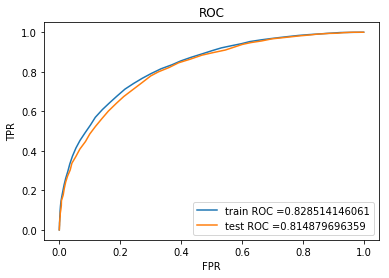

In [86]:
train_fpr, train_tpr, thresholds = roc_curve(Y_train, optimal_model.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y_test, optimal_model.predict_proba(tfidf_sent_vectors_test)[:,1])
AUC8=str(auc(test_fpr, test_tpr))
plt.plot(train_fpr, train_tpr, label="train ROC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test ROC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.show()

## Confusion Matrix

Train confusion matrix
[[4889 1554]
 [1794 4563]]
Test confusion matrix
[[1487  467]
 [ 626 1420]]


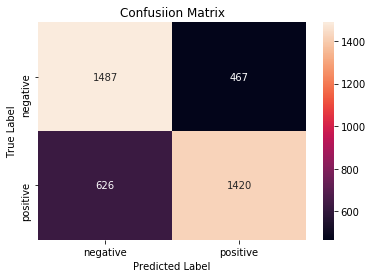

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
optimal_model = KNeighborsClassifier(n_neighbors=59, algorithm='kd_tree')
optimal_model.fit(tfidf_sent_vectors_train, Y_train)
prediction = optimal_model.predict(tfidf_sent_vectors_train)
print("Train confusion matrix") 
print(confusion_matrix(Y_train, optimal_model.predict(tfidf_sent_vectors_train))) 
print("Test confusion matrix")
print(confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test)))
conf_matrix = confusion_matrix(Y_test, optimal_model.predict(tfidf_sent_vectors_test))
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(conf_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# [6] Conclusions

In [97]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
comparision = PrettyTable()
comparision.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
comparision.add_row(["BOW",'brute', optimal_k1, np.round(float(AUC1),3)])
comparision.add_row(["TFIDF", 'brute', optimal_k2, np.round(float(AUC2),3)])
comparision.add_row(["AVG W2V", 'brute', optimal_k3, np.round(float(AUC3),3)])
comparision.add_row(["Weighted W2V", 'brute', optimal_k4, np.round(float(AUC4),3)])
comparision.add_row(["BOW", 'kd_tree', optimal_k5, np.round(float(AUC5),3)])
comparision.add_row(["TFIDF", 'kd_tree', optimal_k6, np.round(float(AUC6),3)])
comparision.add_row(["AVG W2V",'kd_tree', optimal_k7, np.round(float(AUC7),3)])
comparision.add_row(["Weighted W2V", 'kd_tree', optimal_k8, np.round(float(AUC8),3)])
print(comparision)

+--------------+---------+-----------------------------------------------------------------------------+-------+
|  Vectorizer  |  Model  |                                Hyperparameter                               |  AUC  |
+--------------+---------+-----------------------------------------------------------------------------+-------+
|     BOW      |  brute  |  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',  | 0.671 |
|              |         |                   metric_params=None, n_jobs=1, n_neighbors=20, p=2,        |       |
|              |         |                                   weights='uniform')                        |       |
|    TFIDF     |  brute  |  KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',  | 0.864 |
|              |         |                   metric_params=None, n_jobs=1, n_neighbors=49, p=2,        |       |
|              |         |                                   weights='uniform')                 

1. KNN With TFIDF using bruteForce with an  optimal Hyperparameter k = 49, with an accuracy of 0.86%
   compare to other models with good accuracy.
2. Where the Train_error and Test_error of TFIDF are very low compare to other models.
3. TradeOff (or) bias b/w TrainError,ValidationError whenever a model is having increasing TrainError, incrreasing Cross-Val
   Error then the model is underfitting.
4. If the Model is Having less TrainError and high(increasing) Cross-Val Error then the model is Overfittting.
5. For Accuracy by using time based splitting than random split we can improve accuracy, but data in this model
   is not time based split.
6. Even though we got good accuracy of 86% For Tfidf at the time of deployment we may not get the same accuracy
   because it is in't time based split.














































































